In [1]:
import os
import json

import numpy as np
import cv2
from PIL import Image
from typing import Tuple
import matplotlib.pyplot as plt
import hausdorff

kavsir_home = '../datasets/Kvasir-SEG'
kavsir_meta_path = os.path.join(kavsir_home, 'kavsir_bboxes.json')
kavsir_images = os.path.join(kavsir_home, 'images')
kavsir_masks = os.path.join(kavsir_home, 'masks')
new_dataset_home = './aam_datasets'
new_train_images = os.path.join(new_dataset_home, 'trainset')
new_test_images = os.path.join(new_dataset_home, 'testset')
kavsir_meta: dict = json.load(open(kavsir_meta_path, 'r', encoding='utf-8'))

def get_coordinates(img_path: str):
    pts_path = img_path.replace('.jpg', '.pts')
    points, from_ids, to_ids = [], [], []
    for info in open(pts_path, 'r', encoding='utf-8'):
        try:
            x, y = info.split()
            x = int(float(x))
            y = int(float(y))
            points.append((x, y))
        except Exception as e:
            pass
    return np.array(points), from_ids, to_ids

## shape modeling

In [2]:
from shape import shape_mean, shape_modeling, normalise_shape, denormalise_shape
C = []

for image_file in os.listdir(new_train_images):
    if image_file.endswith('.jpg'):           
        image_path = os.path.join(new_train_images, image_file)
        points, _, _ = get_coordinates(image_path)
        if points.shape == (68, 2):
            C.append(points)

C = np.array(C)
s_0, aligned_C, eig_values, eig_vecs = shape_modeling(C)

In [3]:
def compute_min_k(eig_values: np.ndarray, ratio: float) -> int:
    sum_eig_value = eig_values.real.sum()
    accumlate = 0
    k = 0
    for value in eig_values.real:
        k += 1
        accumlate += value
        if accumlate / sum_eig_value > ratio:
            break
    return k

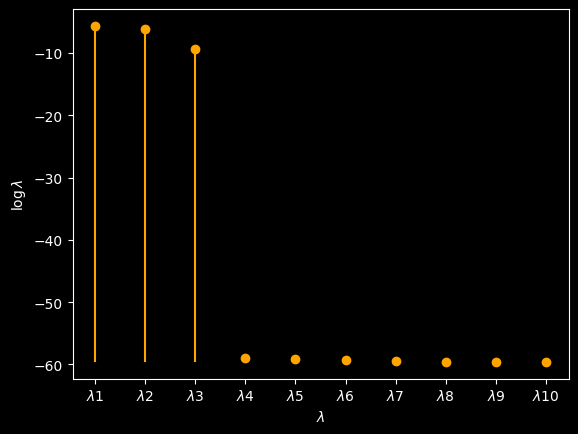

In [4]:
show_eig_values = np.log2(eig_values.real[:10])
plt.plot(np.log2(eig_values.real[:len(show_eig_values)]), 'o', color='orange')
plt.xticks(
    np.arange(len(show_eig_values)),
    [f'$\lambda{i + 1}$' for i in range(len(show_eig_values))]
)
plt.ylabel('$\log \lambda$')
plt.xlabel('$\lambda$')
plt.vlines(np.arange(len(show_eig_values)), ymin=np.ones(len(show_eig_values)) * min(show_eig_values), ymax=show_eig_values, colors='orange')
plt.savefig('./images/shape_modeling_0.png')

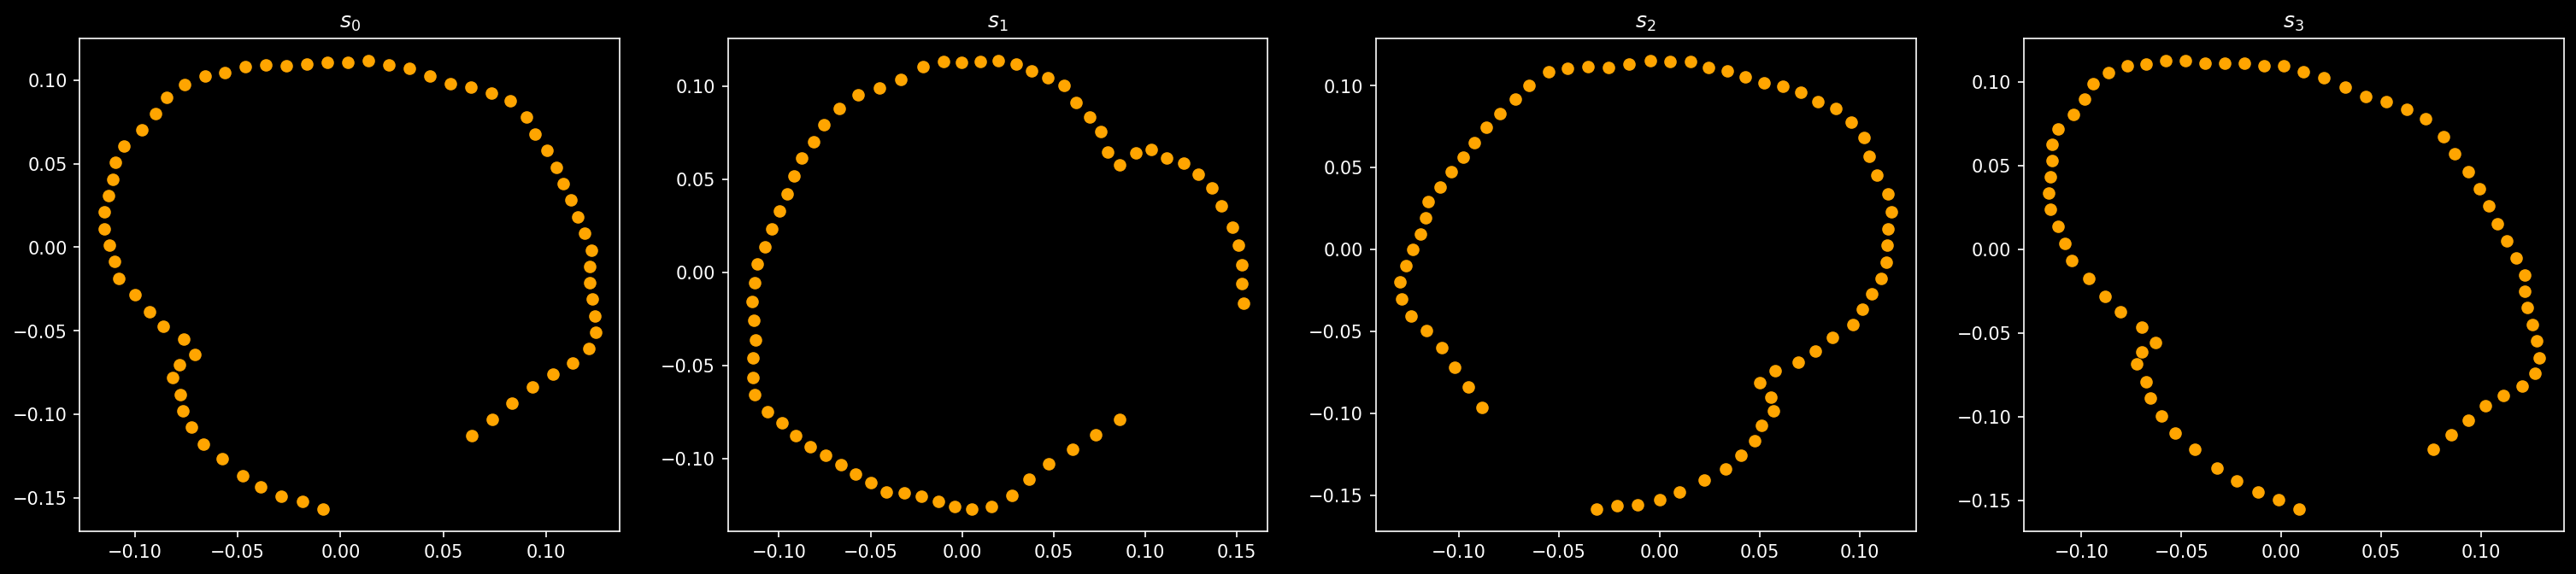

In [5]:
def visualise_shape(s: np.ndarray, title: str):
    x_values = s[0: -2: 2]
    y_values = s[1: -1: 2]
    plt.scatter(x_values.real, y_values.real, marker='o', color='orange')
    plt.title(title)
    
plt.figure(dpi=150, figsize=[25, 5])
plt.subplot(1, 4, 1)
visualise_shape(s_0, '$s_0$')
plt.subplot(1, 4, 2)
visualise_shape(eig_vecs[:, 0], '$s_1$')
plt.subplot(1, 4, 3)
visualise_shape(eig_vecs[:, 1], '$s_2$')
plt.subplot(1, 4, 4)
visualise_shape(eig_vecs[:, 2], '$s_3$')
plt.savefig('./images/shape_modeling_1.png')

## visualise of shape modeling

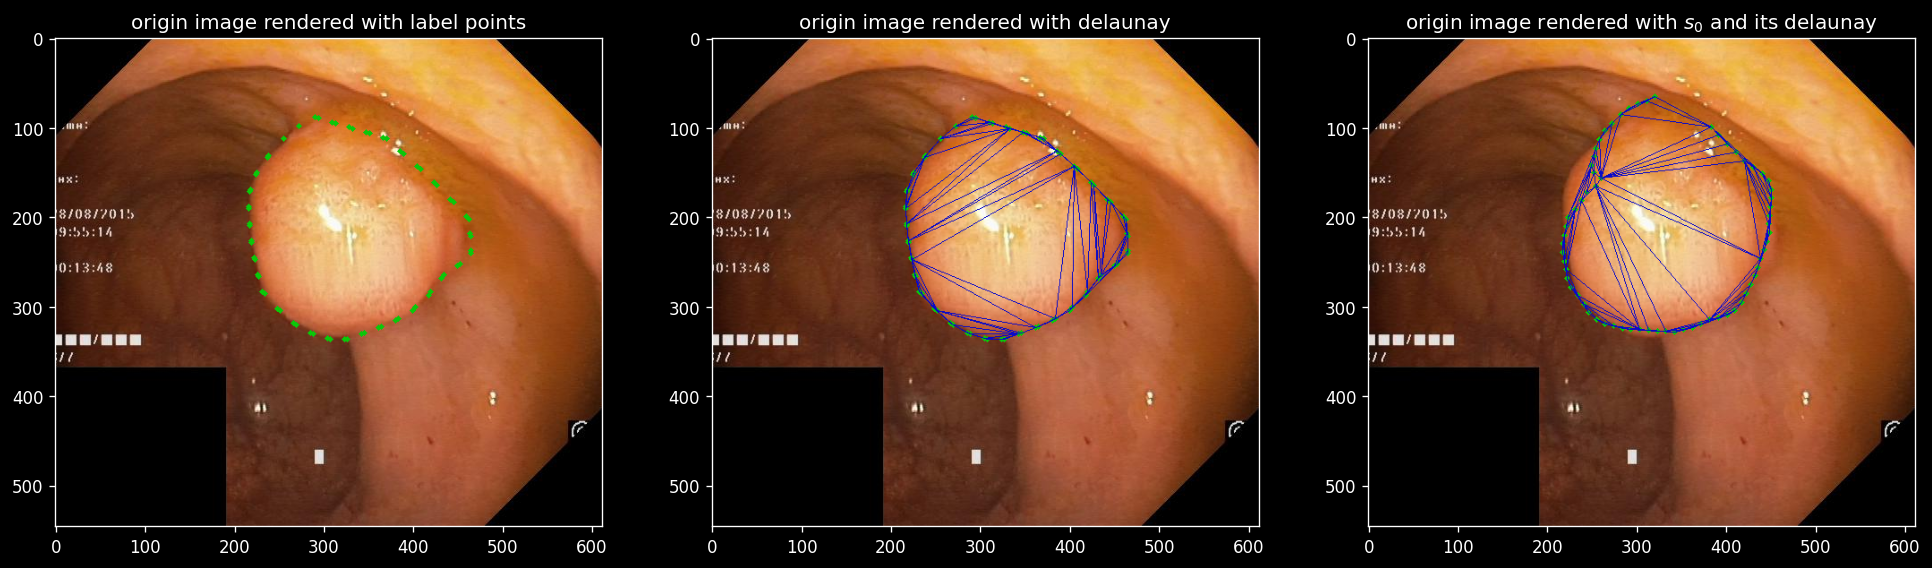

In [6]:
import scipy.spatial
import matplotlib.pyplot as plt

test_image_path = os.path.join(new_train_images, 'cju1csmlc4ht10799b8ymmghg.jpg')
points, _, _ = get_coordinates(test_image_path)
s = np.array(points).reshape(1, -1, 2)
s_0_points = denormalise_shape(s_0.reshape(1, -1, 2), s).reshape(-1, 2).astype(np.int_)
draw_image = cv2.imread(test_image_path)

# draw points
for point in points:
    cv2.circle(draw_image, center=point, radius=1, color=(10, 200, 10), thickness=3)
plt.figure(dpi=120, figsize=[20, 6])
plt.subplot(1, 3, 1)
plt.title('origin image rendered with label points')
plt.imshow(draw_image[..., ::-1])

delaunay = scipy.spatial.Delaunay(points)
for simp in delaunay.simplices:
    cv2.line(draw_image, pt1=points[simp[0]], pt2=points[simp[1]], color=(200, 10, 10), thickness=1)
    cv2.line(draw_image, pt1=points[simp[1]], pt2=points[simp[2]], color=(200, 10, 10), thickness=1)
    cv2.line(draw_image, pt1=points[simp[2]], pt2=points[simp[0]], color=(200, 10, 10), thickness=1)

plt.subplot(1, 3, 2)
plt.title('origin image rendered with delaunay')
plt.imshow(draw_image[..., ::-1])

draw_image = cv2.imread(test_image_path)

delaunay = scipy.spatial.Delaunay(s_0_points)
for point in s_0_points:
    x = int(point[0])
    y = int(point[1])
    cv2.circle(draw_image, center=(x, y), radius=1, color=(10, 200, 10), thickness=3)
    
for simp in delaunay.simplices:
    cv2.line(draw_image, pt1=s_0_points[simp[0]], pt2=s_0_points[simp[1]], color=(200, 10, 10), thickness=1)
    cv2.line(draw_image, pt1=s_0_points[simp[1]], pt2=s_0_points[simp[2]], color=(200, 10, 10), thickness=1)
    cv2.line(draw_image, pt1=s_0_points[simp[2]], pt2=s_0_points[simp[0]], color=(200, 10, 10), thickness=1)

plt.subplot(1, 3, 3)
plt.title('origin image rendered with $s_0$ and its delaunay')
plt.imshow(draw_image[..., ::-1])
plt.savefig('./images/shape_modeling_2.png')

## save shape model

In [7]:
model_params = {
    'shape': {
        'base': s_0,
        'eig_values': eig_values.real[:3],
        'eig_vecs': eig_vecs.real[:3]
    },
    'appearance': {
        'base': None,
        'eig_values': None,
        'eig_vecs': None,
        'beta': None,
        'alpha': None
    }
}

## appearance modeling

In [8]:

import skimage.transform
import tqdm

images = []

for image_file in tqdm.tqdm(os.listdir(new_train_images), colour='green', ncols=80):
    if image_file.endswith('.jpg'):   
        image_path = os.path.join(new_train_images, image_file)
        points, _, _ = get_coordinates(image_path)
        if points.shape == (68, 2):
            image = cv2.imread(image_path, 0)
            h, w = image.shape[:2]
            s = np.array([points])
            real_s_0 = denormalise_shape(s_0.reshape(1, -1, 2), s)
            
            source_control_points = real_s_0.reshape(-1, 2)
            target_control_points = s.reshape(-1, 2)
            
            # 进行仿射变换
            affine_trasnform = skimage.transform.PiecewiseAffineTransform()
            affine_trasnform.estimate(src=source_control_points, dst=target_control_points)
            warped_image = skimage.transform.warp(image, affine_trasnform)
                        
            xmax, ymax = source_control_points.max(axis=0).astype(np.int_)
            xmin, ymin = source_control_points.min(axis=0).astype(np.int_)
            images.append(warped_image[ymin: ymax, xmin: xmax])
     
len(images)        

  0%|                                                  | 0/1030 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 1030/1030 [01:17<00:00, 13.23it/s]


508

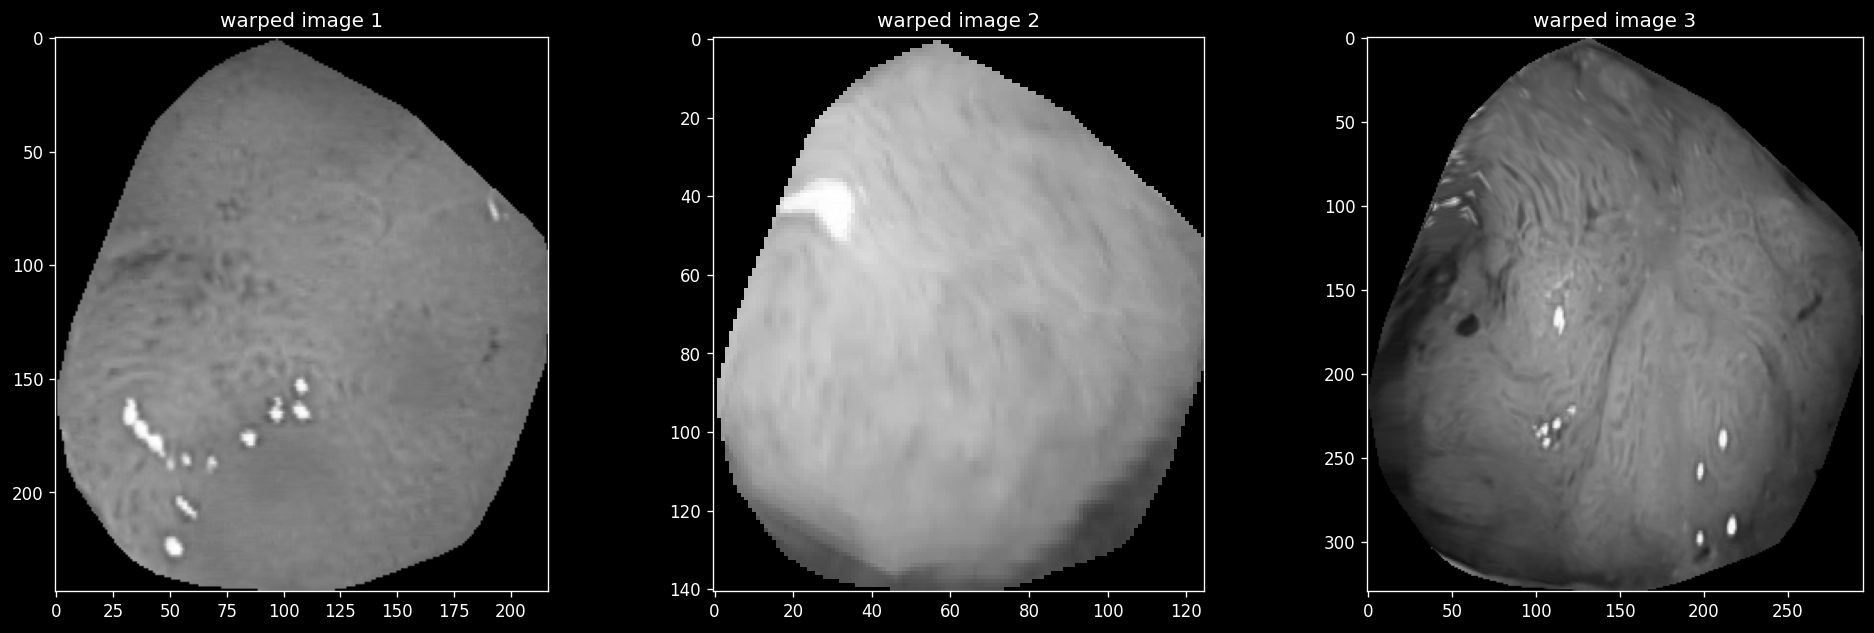

In [9]:
plt.figure(dpi=120, figsize=[20, 6])
plt.subplot(1, 3, 1)
plt.title('warped image 1')
plt.imshow(images[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.title('warped image 2')
plt.imshow(images[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.title('warped image 3')
plt.imshow(images[2], cmap='gray')
plt.savefig('./images/appearance_modeling_0.png')

In [10]:
resize_images = []
for image in images:
    h, w = image.shape[:2]
    if h > 50 and w > 50:
        resize_image = cv2.resize(image, (50, 50))
        resize_images.append(resize_image)
resize_images = np.array(resize_images)

In [11]:
from appearance import appearance_modeling
A_0, normalise_images, eig_values, eig_vecs, beta, alpha = appearance_modeling(resize_images)

model_params['appearance']['base'] = A_0
model_params['appearance']['alpha'] = alpha
model_params['appearance']['beta'] = beta

In [12]:
k_A = compute_min_k(eig_values, 0.99)
model_params['appearance']['eig_values'] = eig_values.real[:k_A]
model_params['appearance']['eig_vecs'] = eig_vecs.real[:k_A]

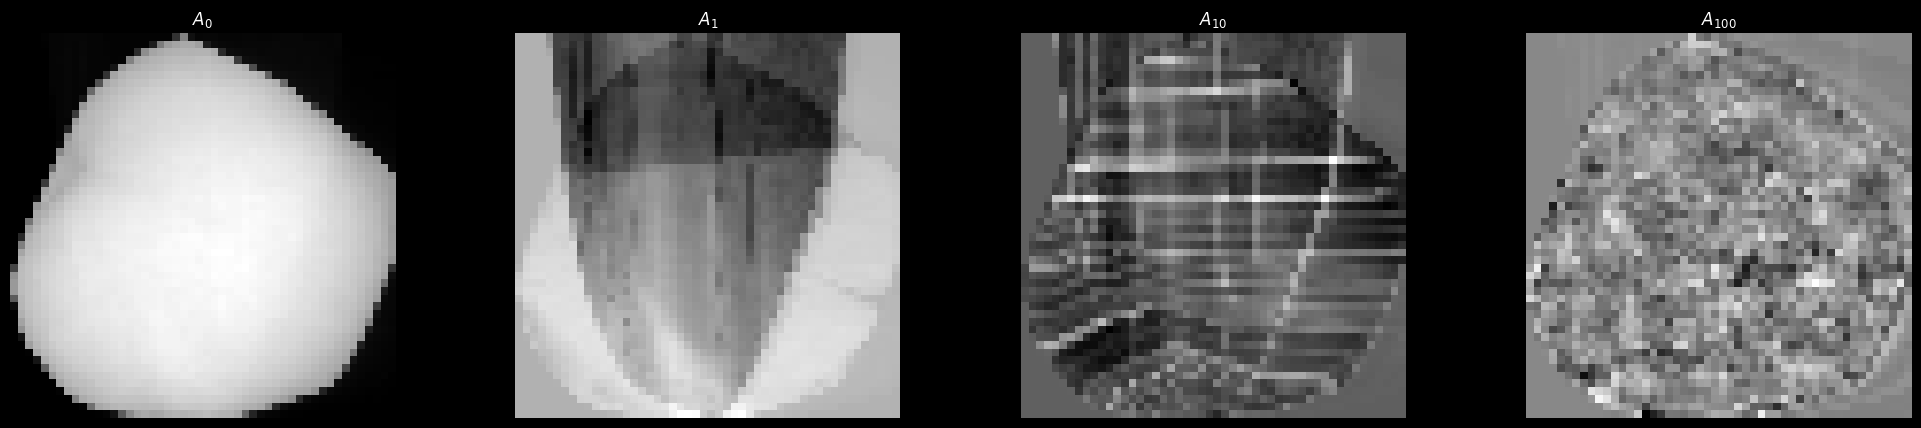

In [13]:
def visualise_appearance(appearance: np.ndarray, title: str):
    image = appearance.real.reshape(50, 50)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    
plt.figure(figsize=[25, 5])
plt.subplot(1, 4, 1)
visualise_appearance(A_0.reshape(-1), '$A_0$')
plt.subplot(1, 4, 2)
visualise_appearance(eig_vecs[:, 0], '$A_1$')
plt.subplot(1, 4, 3)
visualise_appearance(eig_vecs[:, 9], '$A_{10}$')
plt.subplot(1, 4, 4)
visualise_appearance(eig_vecs[:, 99], '$A_{100}$')
plt.savefig('./images/appearance_modeling_1.png')

## save model

In [14]:
np.save('./aam.npy', model_params, allow_pickle=True)

## test model

In [15]:
test_image_path = os.path.join(new_test_images, 'cju2zi4l09f5807991s8do2b2.jpg')
bbox = kavsir_meta['cju2zi4l09f5807991s8do2b2']['bbox'][0]
test_image = cv2.imread(test_image_path)
model_params: dict = np.load('./aam.npy', allow_pickle=True).tolist()

In [16]:
bbox = kavsir_meta['cju2zi4l09f5807991s8do2b2']['bbox'][0]
bbox

{'label': 'polyp', 'xmin': 178, 'ymin': 90, 'xmax': 426, 'ymax': 265}

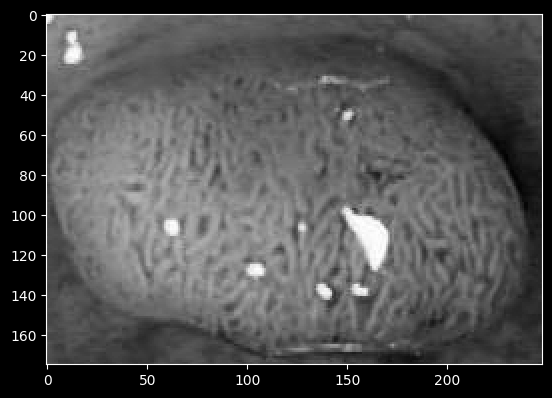

In [17]:
bbox = kavsir_meta['cju2zi4l09f5807991s8do2b2']['bbox'][0]
xmin = bbox['xmin']
ymin = bbox['ymin']
xmax = bbox['xmax']
ymax = bbox['ymax']

roi_image = skimage.color.rgb2gray(test_image[ymin: ymax, xmin: xmax, ::-1])
plt.imshow(roi_image, cmap='gray')

### look at what mask like in the initialised point

In [18]:
eig_num = len(model_params['shape']['eig_values'])
p_s = np.random.randn(3) * 0.1
s_0 = model_params['shape']['base']
s_s  = model_params['shape']['eig_vecs'].real
estimate_shape = s_0 + p_s @ s_s
# def lucas_kanada_optimiser(input_image: np.ndarray, model_params: dict, max_iter: int = 20):
#     assert len(input_image.shape) == 2
#     init_ps = np.random.randn(3)

In [19]:
def shape_shift(shape, roi_image):
    roi_h, roi_w = roi_image.shape[:2]
    coords = shape.reshape(-1, 2)
    coords[:, 0] = (coords[:, 0] - coords[:, 0].min()) / (coords[:, 0].max() - coords[:, 0].min())
    coords[:, 1] = (coords[:, 1] - coords[:, 1].min()) / (coords[:, 1].max() - coords[:, 1].min())
    coords[:, 0] = coords[:, 0] * roi_w
    coords[:, 1] = coords[:, 1] * roi_h
    shape = coords.reshape(-1)
    return shape

estimate_shape = shape_shift(estimate_shape, roi_image)
s_0 = shape_shift(s_0, roi_image)

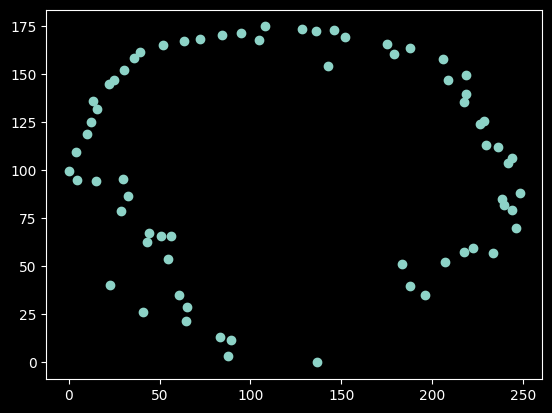

In [20]:
coords = estimate_shape.reshape(-1, 2)
plt.scatter(coords[:, 0], coords[:, 1])

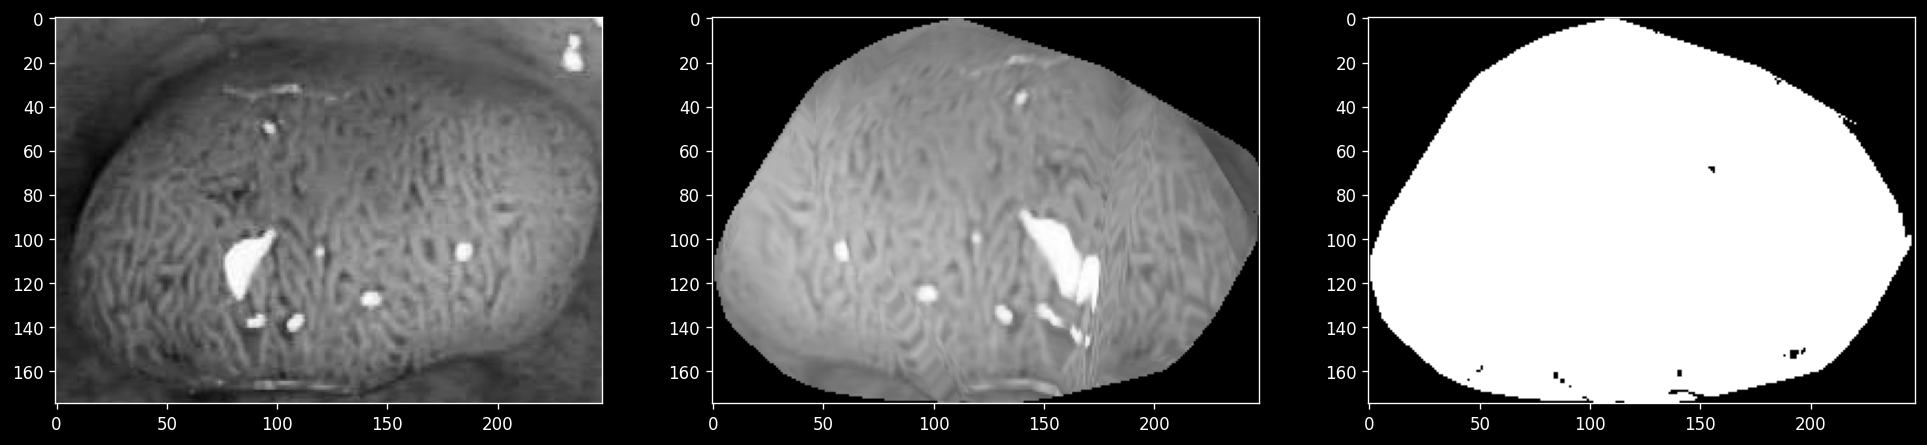

In [21]:
source_control_points = s_0.reshape(-1, 2)
target_control_points = estimate_shape.reshape(-1, 2)
# 进行仿射变换
affine_trasnform = skimage.transform.PiecewiseAffineTransform()
affine_trasnform.estimate(src=source_control_points, dst=target_control_points)
warped_image = skimage.transform.warp(roi_image, affine_trasnform)

_, mask = cv2.threshold(warped_image * 255, 100, 255, cv2.THRESH_BINARY)

plt.figure(dpi=120, figsize=[20, 6])
plt.subplot(1, 3, 1)
plt.imshow(roi_image[..., ::-1], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(warped_image, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.savefig('./images/test_model.png')

### make cost function

$$
E(p) = \sum_{x} \left[ A_0(x) - I(W(x;p)) \right]^2
$$

In [22]:
import scipy.optimize

def calculate_warp_image(p: np.ndarray):
    estimate_shape = s_0 + p @ s_s
    estimate_shape = shape_shift(estimate_shape, roi_image)
    source_control_points = s_0.reshape(-1, 2)
    target_control_points = estimate_shape.reshape(-1, 2)
    # 进行仿射变换
    affine_trasnform = skimage.transform.PiecewiseAffineTransform()
    affine_trasnform.estimate(src=source_control_points,
                              dst=target_control_points)
    warped_image = skimage.transform.warp(roi_image, affine_trasnform)
    return warped_image


def cost_function(p: np.ndarray):
    warped_image = calculate_warp_image(p)
    h, w = warped_image.shape
    resize_A_0 = cv2.resize(A_0[0], (w, h))
    cost = np.sum((resize_A_0 - warped_image)**2)
    return cost


res_p = scipy.optimize.minimize(cost_function,
                                p_s,
                                method='nelder-mead',
                                options={
                                    'disp': True
                                })


Optimization terminated successfully.
         Current function value: 26426.002932
         Iterations: 294
         Function evaluations: 526


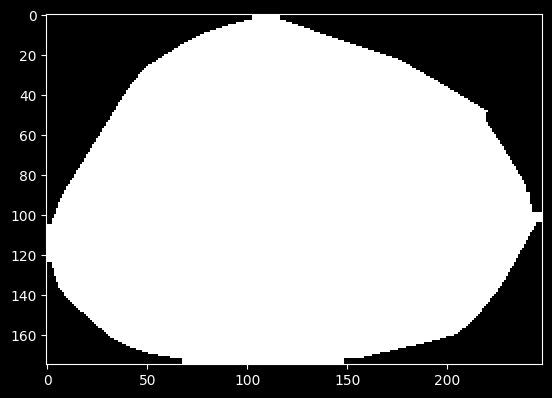

In [23]:
warp_image = calculate_warp_image(res_p.x)
_, mask = cv2.threshold(warped_image * 255, 100, 255, cv2.THRESH_BINARY)
kernel = np.ones([5, 5])
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
plt.imshow(mask, cmap='gray')

In [24]:
gt_image = cv2.imread('../datasets/Kvasir-SEG/masks/cju2zi4l09f5807991s8do2b2.jpg')
gt_image = skimage.color.rgb2gray(gt_image[ymin: ymax, xmin: xmax, ::-1])
gt_image = gt_image * 255

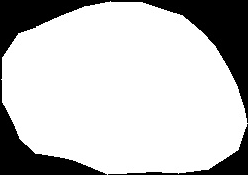

In [25]:
Image.fromarray(gt_image.astype('uint8'))

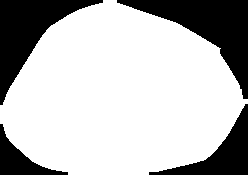

In [26]:
Image.fromarray(mask.astype('uint8'))

In [27]:
def transform_image_data(predict: np.ndarray, label: np.ndarray):
    predict = predict.astype(np.bool_).astype(np.int_)
    label = label.astype(np.bool_).astype(np.int_)
    return predict, label

def dice_coef(predict: np.ndarray, label: np.ndarray, epsilon: float = 1e-5) -> float:
    predict, label = transform_image_data(predict, label)
    intersection = (predict * label).sum()
    return (2. * intersection + epsilon) / (predict.sum() + label.sum() + epsilon)

def iou_score(predict: np.ndarray, label: np.ndarray, epsilon: float = 1e-5) -> float:
    predict, label = transform_image_data(predict, label)
    intersection = (predict & label).sum()
    union = (predict | label).sum()
    return (intersection + epsilon) / (union + epsilon)

def sensitivity(predict: np.ndarray, label: np.ndarray, epsilon: float = 1e-5) -> float:
    predict, label = transform_image_data(predict, label)
    intersection = (predict * label).sum()
    return (intersection + epsilon) / (label.sum() + epsilon)

def ppv(predict: np.ndarray, label: np.ndarray, epsilon: float = 1e-5) -> float:
    predict, label = transform_image_data(predict, label)
    intersection = (predict * label).sum()
    return (intersection + epsilon) / (predict.sum() + epsilon)

def hd95(predict: np.ndarray, label: np.ndarray, distance="euclidean"):
    predict = predict.flatten()[..., None]
    label = label.flatten()[..., None]
    distance = hausdorff.hausdorff_distance(predict, label, distance=distance)
    return distance * 0.95

In [28]:
metrics = {
    'Dice': dice_coef,
    'IoU': iou_score,
    'sensitivity': sensitivity,
    'ppv': ppv,
    'HD95': hd95
}

for metric_name in metrics:
    print('{}:{}'.format(metric_name, metrics[metric_name](mask, gt_image)))

Dice:0.9211286784293625
IoU:0.8537891962041315
sensitivity:0.8865622087935221
ppv:0.9584999527823609
HD95:6.6499999999999995
